In [69]:
import pyspark as ps
import pandas as pd
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
from pyspark.sql.functions import substring, count, concat, col, lit, round, when, unix_timestamp, date_format, month, year
import json
import time

#  Getting Started

## Download Data

Using cURL instead of Kaggle cause kagglehub only downloads to outside your project directory and Kaggle needs authentification...
 
uhhhe, gross!

In [22]:
!curl -L -o archive.zip https://www.kaggle.com/api/v1/datasets/download/sobhanmoosavi/us-accidents

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  653M  100  653M    0     0  41.2M      0  0:00:15  0:00:15 --:--:-- 41.6M


In [26]:
!unzip archive.zip

Archive:  archive.zip
  inflating: US_Accidents_March23.csv  


## Create Spark Session

I'll use pyspark first cause it's optimized for large data. By the end of the section we will output a pandas dataframe which is more familiar to everybody.

In [13]:
# Initialize Spark Session
spark = SparkSession.builder.appName("US_Accidents_Analysis").getOrCreate()

# Load the CSV file into a DataFrame
df = spark.read.option("header", "true").option("inferSchema", "true").csv("US_Accidents_March23.csv")

In [15]:
df.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

# Data Cleaning

## Drop Unusable Variables

Some of the variables simply don't make sense and will not contribute to our model.

Some are debatable.

### Assess weather condition stay or leave

In [10]:
df.select("Weather_Condition").distinct().collect()

[Row(Weather_Condition='Ice Pellets'),
 Row(Weather_Condition='Shallow Fog'),
 Row(Weather_Condition='Thunderstorm'),
 Row(Weather_Condition='Volcanic Ash'),
 Row(Weather_Condition='N/A Precipitation'),
 Row(Weather_Condition='Showers in the Vicinity'),
 Row(Weather_Condition='Cloudy'),
 Row(Weather_Condition='Light Freezing Rain'),
 Row(Weather_Condition='Blowing Snow'),
 Row(Weather_Condition='Heavy Rain / Windy'),
 Row(Weather_Condition='Low Drifting Snow'),
 Row(Weather_Condition='Heavy Thunderstorms and Snow'),
 Row(Weather_Condition='Widespread Dust'),
 Row(Weather_Condition='Snow Grains'),
 Row(Weather_Condition='Light Rain with Thunder'),
 Row(Weather_Condition='Squalls'),
 Row(Weather_Condition='Scattered Clouds'),
 Row(Weather_Condition='Heavy T-Storm'),
 Row(Weather_Condition='Patches of Fog'),
 Row(Weather_Condition='Rain Showers'),
 Row(Weather_Condition='Thunderstorms and Rain'),
 Row(Weather_Condition='Drizzle'),
 Row(Weather_Condition='Cloudy / Windy'),
 Row(Weather_Con

Weather condition has too many variables.. we drop it for now cause other numeric parameters should be sufficient.

### Assess day/night condition stay or leave

In [11]:
df.select("Sunrise_Sunset").distinct().show()

+--------------+
|Sunrise_Sunset|
+--------------+
|         Night|
|           Day|
|          NULL|
+--------------+



It'll stay as a boolean.

In [20]:
df = df.withColumn(
    "Day_Night",
    when(col("Sunrise_Sunset") == "Day", 1)
    .when(col("Sunrise_Sunset") == "Night", 0)
    .otherwise(None)  # You can replace None with a value, such as -1, to handle NULL cases
)

### Start Dropping

Some of the variables simply don't make sense and will not contribute to our model.

In [21]:
# Drop the unnecessary columns including ID and Source
df_cleaned = df.drop("Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Description", "ID", "Source", 
                     "Distance", "Street", "City", "County", "State", "Country", "Timezone", "Airport_code", 
                     "Weather_Condition", "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", 
                     "Roundabout", "Weather_Timestamp", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", 
                     "Astronomical_Twilight", "Nautical_Twilight", "Civil_Twilight")

# Show the first 5 rows of the cleaned DataFrame to verify the columns were removed
df_cleaned.show(5, truncate=False)

+--------+-------------------+-------------------+------------+----------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------------+---------+
|Severity|Start_Time         |End_Time           |Distance(mi)|Zipcode   |Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Sunrise_Sunset|Day_Night|
+--------+-------------------+-------------------+------------+----------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------------+---------+
|3       |2016-02-08 05:46:00|2016-02-08 11:00:00|0.01        |45424     |36.9          |NULL         |91.0       |29.68       |10.0          |Calm          |NULL           |0.02             |Night         |0        |
|2       |2016-02-08 06:07:59|2016-02-08 06:37:59|0.01        |43068-3402|37.9          |NULL         |100.0      |29.65       |

In [22]:
df = df_cleaned

## Drop Null

In [23]:
df.count()

7728394

In [24]:
df = df.dropna()

In [25]:
df.count()

5227072

## Create Duration feature

In [29]:
df = df.withColumn(
    "duration_minutes",
    (unix_timestamp(col("end_time")) - unix_timestamp(col("start_time"))) / 60
)

In [31]:
df.show(5)

+--------+-------------------+-------------------+------------+----------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------------+---------+----------------+
|Severity|         Start_Time|           End_Time|Distance(mi)|   Zipcode|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Sunrise_Sunset|Day_Night|duration_minutes|
+--------+-------------------+-------------------+------------+----------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------------+---------+----------------+
|       3|2016-02-08 07:44:26|2016-02-08 08:14:26|        0.01|     43081|          37.9|         35.5|       97.0|       29.63|           7.0|           SSW|            3.5|             0.03|           Day|        1|            30.0|
|       3|2016-02-08 08:10:04|2016-02-08 08:40:04|        0.

## Create Day, Month, Year Categorical Variables

In [37]:
# Step 1: Extract "day_of_week" as a string, "month", and "year"
df = df.withColumn("day_of_week_str", date_format(col("start_time"), "E")) \
       .withColumn("month", month(col("start_time"))) \
       .withColumn("year", year(col("start_time")))

# Step 2: Map the day_of_week_str to numeric values (Mon = 1, ..., Sun = 7)
df = df.withColumn(
    "day_of_week",
    when(col("day_of_week_str") == "Mon", 1)
    .when(col("day_of_week_str") == "Tue", 2)
    .when(col("day_of_week_str") == "Wed", 3)
    .when(col("day_of_week_str") == "Thu", 4)
    .when(col("day_of_week_str") == "Fri", 5)
    .when(col("day_of_week_str") == "Sat", 6)
    .when(col("day_of_week_str") == "Sun", 7)
    .otherwise(None)
)

# Step 3: (Optional) Drop the "day_of_week_str" column if you no longer need it
df = df.drop("day_of_week_str")
df.show(5)

+--------+-------------------+-------------------+------------+----------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------------+---------+----------------+-----------+-----+----+
|Severity|         Start_Time|           End_Time|Distance(mi)|   Zipcode|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Sunrise_Sunset|Day_Night|duration_minutes|day_of_week|month|year|
+--------+-------------------+-------------------+------------+----------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------------+---------+----------------+-----------+-----+----+
|       3|2016-02-08 07:44:26|2016-02-08 08:14:26|        0.01|     43081|          37.9|         35.5|       97.0|       29.63|           7.0|           SSW|            3.5|             0.03|           Day|        1|         

## Geolocation Processing - ZIP Code to Population

Due to an imbalance of geolocation data, I propose we use population as a continuous to replace ZIP code.

In [44]:
# First let's truncate zipcode to only 5 digits
df = df.withColumn("Zipcode", substring("Zipcode", 1, 5))

In [50]:
unique_zipcodes = [row["Zipcode"] for row in df.select("Zipcode").distinct().collect()]

### Imbalance of ZIP Code Distribution

In [52]:
len(unique_zipcodes)

20305

In [46]:
# Group by the first five digits of the zip code and count the occurrences
df_zipcode_histogram = df.groupBy("Zipcode").agg(count("*").alias("count"))

# Display the top 10 zip codes by frequency
df_zipcode_histogram.orderBy("count", ascending=False).show(10, truncate=False)

+-------+-----+
|Zipcode|count|
+-------+-----+
|33186  |10560|
|32819  |9841 |
|27610  |8767 |
|91761  |8610 |
|33155  |8341 |
|70808  |7764 |
|32837  |7753 |
|92407  |7590 |
|37211  |7480 |
|33169  |7395 |
+-------+-----+
only showing top 10 rows



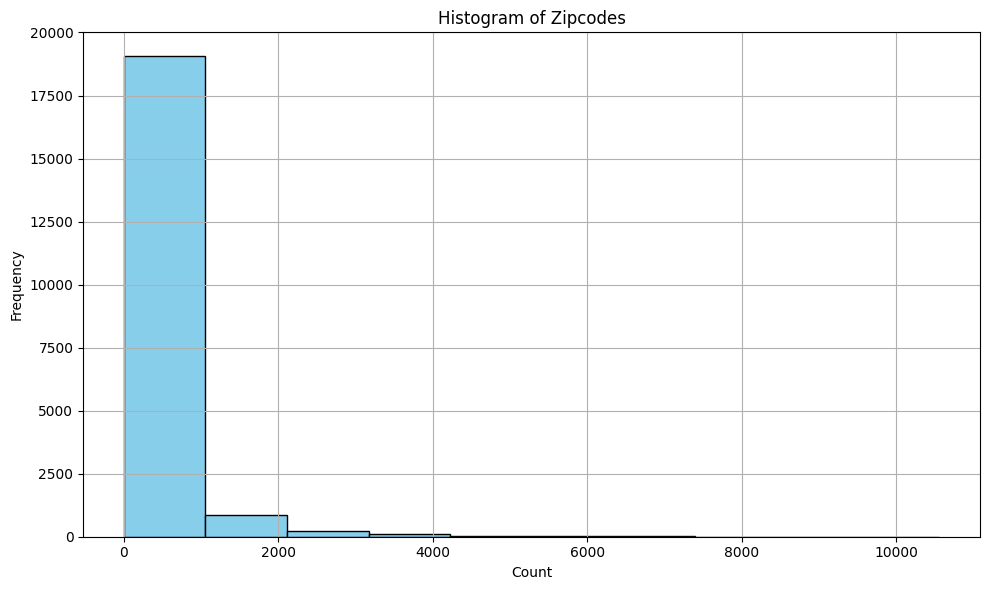

In [47]:
df_zipcode_histogram_pd = df_zipcode_histogram.toPandas()


plt.figure(figsize=(10, 6))
plt.hist(df_zipcode_histogram_pd['count'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Histogram of Zipcodes')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

### Calling Census API to Get Population by ZCTA

Go to this website
https://data.census.gov/table?q=demographics&g=860XX00US30318

WARNING: very time consuming to run

In [87]:
# Base URL for the Census ACS 2022 Profile API
BASE_URL = "https://api.census.gov/data/2022/acs/acs5/profile"

def get_population_data(zip_code):
    params = {
        "get": "group(DP05)",
        "for": f"zip code tabulation area:{zip_code}",
        "key": "67c2f8800849799333a9ee74d25c60a4630b3db1"
    }

    try:
        response = requests.get(BASE_URL, params=params)

        if response and response.status_code == 429:
            print(f"Rate limit hit for ZIP code {zip_code}. Waiting 0.5 seconds before retrying...")
            time.sleep(0.6)

        if response.status_code != 200:
            print(f"Error: Received status code {response.status_code} for ZIP code {zip_code}")
            return None

        # Parse the JSON response
        data = response.json()

        # Extract the population value from data[1][0]
        if len(data) > 1 and len(data[1]) > 0:
            population = data[1][0]
            return int(population)
        else:
            print(f"No valid data found for ZIP code {zip_code}.")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error: {e} for ZIP code {zip_code}")
        return None

    except ValueError as e:
        print(f"JSON Parsing Error: {e} for ZIP code {zip_code}")
        return None

# Example usage
get_population_data("30318")

59559

In [96]:
# Iterate over unique zip codes and fetch population data
for i, zipcode in enumerate(unique_zipcodes):
    try:
        # Skip if population data already exists for this zip code
        if zipcode_population_mapping.get(zipcode) is not None:
            continue
        
        # Update the dictionary
        zipcode_population_mapping[zipcode] = get_population_data(zipcode)
        
        # Print progress for every 1000th ZIP code
        if (i + 1) % 1000 == 0:
            print(f"Processed {i + 1} ZIP codes out of {len(unique_zipcodes)}")

    except Exception as e:
        print(f"An error occurred while processing ZIP code {zipcode}: {e}")
        continue  # Continue to the next ZIP code if an error occurs

Error: Received status code 204 for ZIP code 20041
Error: Received status code 204 for ZIP code 60666
Error: Received status code 204 for ZIP code 37240
Error: Received status code 204 for ZIP code 33199
Error: Received status code 204 for ZIP code 80225
Processed 4000 ZIP codes out of 20305
Processed 5000 ZIP codes out of 20305
Error: Received status code 204 for ZIP code 37246
Error: Received status code 204 for ZIP code 80523
Error: Received status code 204 for ZIP code 22649
Error: Received status code 204 for ZIP code 65211
Error: Received status code 204 for ZIP code 91523
Processed 6000 ZIP codes out of 20305
Error: Received status code 204 for ZIP code 95192
Error: Received status code 204 for ZIP code 62071
Processed 7000 ZIP codes out of 20305
Error: Received status code 204 for ZIP code 36349
Error: Received status code 204 for ZIP code 32611
Error: Received status code 204 for ZIP code 10104
Error: Received status code 204 for ZIP code 32815
Error: Received status code 204 

KeyboardInterrupt: 

In [67]:
len(zipcode_population_mapping)

20305

In [ ]:
broadcast_zipcode_population = spark.sparkContext.broadcast(zipcode_population_mapping)

In [81]:
non_null_count = len([zipcode for zipcode, population in zipcode_population_mapping.items() if population is not None])

print(f"Number of ZIP codes with non-null population data: {non_null_count}")

Number of ZIP codes with non-null population data: 3543


## Summary of Variables

In [58]:
df.printSchema()

root
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Sunrise_Sunset: string (nullable = true)
 |-- Day_Night: integer (nullable = true)
 |-- duration_minutes: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)

